#### Import all necessary tools and libs

In [2]:
%matplotlib inline

import functools
import itertools
import re

import nltk
import numpy as np
import pandas as pd

from collections import Counter

from scipy import stats

### Load our dataset into pandas dataframe using pd.read_csv

In [3]:
chats = pd.read_csv('new_dataset_bahasa.csv')
chats = chats[chats['category'].notnull()]
chats = chats.drop(['id', 'created_at', 'via', 'locale'], axis=1)

#### CX team defined the problem category into several levels, this part below is simply to split the category into several levels

In [4]:
def split_category(category):
    categories = category.split('__')
    if len(categories) < 4:
        categories += [None] * (4 - len(categories))
    return categories

In [4]:
chats['category_0'], chats['category_1'], chats['category_2'], chats['category_3'] = zip(*chats['category'].apply(split_category))

In [5]:
category_2 = chats['category_2'].value_counts()

### Distribution of chat categories

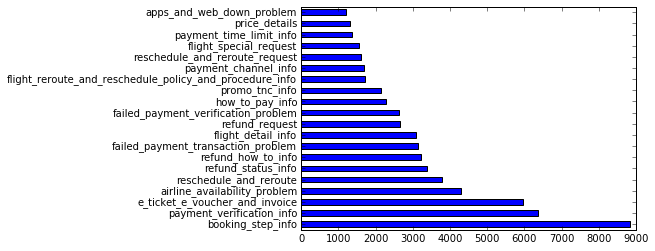

In [6]:
category_2[:20].plot(kind='barh')

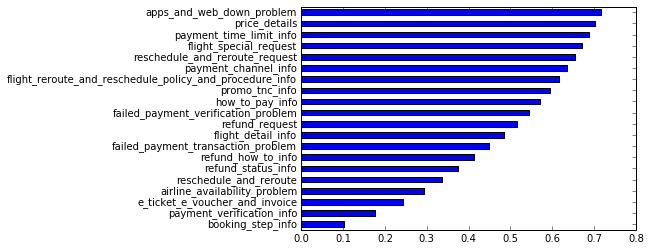

In [7]:
(category_2[:20].cumsum() / category_2.cumsum().max()).plot(kind='barh')

In [8]:
chats['category_012'] = chats['category_0'].str.cat(chats['category_1'], sep='__').str.cat(chats['category_2'], sep='__')

In [9]:
chats['category_012'].value_counts().count()

111

In [10]:
chats['category_2'].value_counts().count()

111

### Mean of chat length

In [11]:
chat_strs = list(chats['description'])

In [12]:
chat_list = [re.split(r'\(\d{,2}:\d{,2}:\d{,2} (?:AM|PM)\) ', x) for x in chat_strs]

In [13]:
chat_list = [map(str.strip, chat) for chat in chat_list]

In [14]:
chat_list = [filter(str.strip, chat) for chat in chat_list]

In [15]:
def discard_timestamp(chat):
    return [re.sub(r'\(\d{,2}:\d{,2}:\d{,2} (AM|PM)\) ', '', message)
            for message in chat]

In [16]:
def filter_customer_chat(chat):
    try:
        first_customer_chat = chat[2]
        customer_name = first_customer_chat.split(':')[0].strip()
        return filter(lambda x: x.startswith(customer_name), chat)
    except:
        return chat

In [17]:
def strip_username(chat):
    return [''.join(message.split(': ')[1:])
            for message in chat]

In [18]:
clean_chat = chat_list

for preprocess in (discard_timestamp, filter_customer_chat, strip_username):
    clean_chat = map(preprocess, clean_chat)

In [19]:
chat_lengths = map(len, clean_chat)
print(np.mean(chat_lengths))
print(np.std(chat_lengths))

6.98196579078
7.06814467512


### Mean of message length

In [20]:
all_messages = list(itertools.chain.from_iterable(clean_chat))

In [21]:
def count_num_words(message):
    return len(message.split(' '))

In [22]:
message_lengths = map(count_num_words, all_messages)
print(np.mean(message_lengths))
print(np.std(message_lengths))

8.00956852859
19.5435017105


In [23]:
np.median(message_lengths)

5.0

In [24]:
stats.mode(message_lengths)

ModeResult(mode=array([1]), count=array([101345]))

### Top n-grams

In [25]:
def discard_non_alphabetic(message):
    return re.sub(r'[^a-z]+', ' ', message.lower()).strip()

In [26]:
def discard_url(message):
    return re.sub(r'((https?://)|(www\.))\S+\s?', '', message.lower()).strip()

In [27]:
messages_no_url = filter(bool, map(discard_url, all_messages))
messages_alpha_only = filter(bool, map(discard_non_alphabetic, messages_no_url))

In [28]:
MAX_N_GRAMS = 4
n_grams = [None] * (MAX_N_GRAMS + 1)

for i in range(1, MAX_N_GRAMS + 1):
    i_grams = map(functools.partial(nltk.ngrams, n=i),
                  map(str.split, messages_alpha_only))
    i_grams = list(itertools.chain.from_iterable(map(list, i_grams)))
    i_grams = [' '.join(x) for x in i_grams]
    n_grams[i] = i_grams

In [29]:
n_grams_counter = map(Counter, n_grams)

In [30]:
n_grams_counter[1].most_common(32)

[('saya', 218789),
 ('di', 72590),
 ('bisa', 64954),
 ('ya', 59647),
 ('sudah', 59425),
 ('tiket', 58737),
 ('ada', 57269),
 ('untuk', 56784),
 ('mau', 51161),
 ('dan', 46958),
 ('tidak', 43152),
 ('ke', 42700),
 ('ini', 42599),
 ('yang', 38499),
 ('traveloka', 37270),
 ('sy', 34757),
 ('yg', 34345),
 ('kami', 31781),
 ('mbak', 31525),
 ('mba', 29491),
 ('apakah', 29065),
 ('kasih', 28936),
 ('booking', 28908),
 ('terima', 28778),
 ('nya', 28647),
 ('hotel', 28619),
 ('refund', 26949),
 ('dari', 26395),
 ('itu', 26368),
 ('pembayaran', 25956),
 ('no', 25853),
 ('dengan', 24808)]

In [31]:
n_grams_counter[2].most_common(32)

[('terima kasih', 25538),
 ('saya mau', 22628),
 ('saya sudah', 13921),
 ('mau tanya', 11126),
 ('tidak ada', 10643),
 ('lion air', 8842),
 ('tidak bisa', 8381),
 ('no pesanan', 7940),
 ('atas nama', 7260),
 ('pesan tiket', 6721),
 ('tiket pesawat', 6658),
 ('saya ingin', 6610),
 ('kode booking', 6550),
 ('saat ini', 6073),
 ('check in', 5764),
 ('chat ini', 5758),
 ('hari ini', 5723),
 ('bisa di', 5709),
 ('sudah cukup', 5659),
 ('selamat siang', 5463),
 ('kami akan', 5341),
 ('kartu kredit', 5001),
 ('saya tidak', 4965),
 ('cukup jelas', 4893),
 ('apakah bisa', 4733),
 ('selamat pagi', 4721),
 ('saya coba', 4709),
 ('selamat malam', 4693),
 ('gmail com', 4544),
 ('saya pesan', 4461),
 ('di traveloka', 4430),
 ('air asia', 4312)]

In [32]:
n_grams_counter[3].most_common(32)

[('saya mau tanya', 4726),
 ('sudah cukup jelas', 3237),
 ('bergabung dalam chat', 2830),
 ('telah bergabung dalam', 2797),
 ('saat ini kami', 2547),
 ('terima kasih atas', 2459),
 ('ini kami akan', 2365),
 ('pojok kanan atas', 2293),
 ('di pojok kanan', 2287),
 ('apabila ada pertanyaan', 2284),
 ('akhiri chat ini', 2282),
 ('dan kami akan', 2280),
 ('klik thumbs up', 2278),
 ('kami hari ini', 2276),
 ('diberikan kepada kami', 2276),
 ('yang diberikan kepada', 2276),
 ('masukan yang diberikan', 2275),
 ('akan akhiri chat', 2275),
 ('kembali dan kami', 2274),
 ('up di pojok', 2274),
 ('kepada kami sangat', 2274),
 ('hari ini sangat', 2274),
 ('thumbs up di', 2274),
 ('kami akan akhiri', 2274),
 ('ini sangat baik', 2273),
 ('membantu jika pelayanan', 2273),
 ('silakan dapat chat', 2273),
 ('chat kembali dan', 2273),
 ('kami sangat kami', 2273),
 ('jika pelayanan kami', 2273),
 ('sangat baik silakan', 2273),
 ('pelayanan kami hari', 2273)]

In [33]:
n_grams_counter[4].most_common(32)

[('telah bergabung dalam chat', 2797),
 ('saat ini kami akan', 2359),
 ('di pojok kanan atas', 2283),
 ('diberikan kepada kami sangat', 2274),
 ('akan akhiri chat ini', 2274),
 ('up di pojok kanan', 2274),
 ('klik thumbs up di', 2274),
 ('thumbs up di pojok', 2274),
 ('apabila ada pertanyaan silakan', 2273),
 ('ada pertanyaan silakan dapat', 2273),
 ('kanan atas dan masukan', 2273),
 ('akan senang untuk membantu', 2273),
 ('kami akan akhiri chat', 2273),
 ('masukan yang diberikan kepada', 2273),
 ('kami hari ini sangat', 2273),
 ('dan masukan yang diberikan', 2273),
 ('kami akan senang untuk', 2273),
 ('ini kami akan akhiri', 2273),
 ('pertanyaan silakan dapat chat', 2273),
 ('pojok kanan atas dan', 2273),
 ('baik silakan klik thumbs', 2273),
 ('hari ini sangat baik', 2273),
 ('sangat baik silakan klik', 2273),
 ('yang diberikan kepada kami', 2273),
 ('dan kami akan senang', 2273),
 ('membantu jika pelayanan kami', 2273),
 ('untuk membantu jika pelayanan', 2273),
 ('jika pelayanan kami